In [1]:
%load_ext autoreload
%autoreload 2

import gc
import logging
import os
import pickle
import sys

import anndata as ad
import numpy as np
import torch
import pandas as pd
import scanpy as sc
import scipy
import yaml

import scglue
import seaborn as sns
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

In [2]:
root_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main'

In [3]:
## VIASH START
dataset_path = os.path.join(root_dir, 'output/datasets/match_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_')
pretrain_path = os.path.join(root_dir, "output/pretrain/clue/openproblems_bmmc_cite_phase2_mod2.clue_train.output_pretrain/default")

par = {
    'input_train_mod1': f'{dataset_path}train_mod1.h5ad',
    'input_train_mod2': f'{dataset_path}train_mod2.h5ad',
    'input_train_sol': f'{dataset_path}train_sol.h5ad',
    'input_test_sol': f'{dataset_path}test_sol.h5ad',
    'input_test_mod1': f'{dataset_path}test_mod1.h5ad',
    'input_test_mod2': f'{dataset_path}test_mod2.h5ad',
    'input_pretrain': pretrain_path,
    'output': 'output.h5ad'
}
meta = {
    'resources_dir': os.path.join(root_dir, 'src/match_modality/methods/clue/resources'),
    'functionality_name': 'clue'
}

In [4]:
sys.path.append(meta['resources_dir'])
import utils

In [5]:
logging.info('Reading `h5ad` files...')
input_train_mod1 = ad.read_h5ad(par['input_train_mod1'])
input_train_mod2 = ad.read_h5ad(par['input_train_mod2'])
input_train_sol = ad.read_h5ad(par['input_train_sol'])
input_test_mod1 = ad.read_h5ad(par['input_test_mod1'])
input_test_mod2 = ad.read_h5ad(par['input_test_mod2'])

input_train_mod1.X = input_train_mod1.X.astype(np.float32)
input_train_mod2.X = input_train_mod2.X.astype(np.float32)
input_test_mod1.X = input_test_mod1.X.astype(np.float32)
input_test_mod2.X = input_test_mod2.X.astype(np.float32)
input_train_mod1.layers["counts"] = input_train_mod1.layers["counts"].astype(np.float32)
input_train_mod2.layers["counts"] = input_train_mod2.layers["counts"].astype(np.float32)
input_test_mod1.layers["counts"] = input_test_mod1.layers["counts"].astype(np.float32)
input_test_mod2.layers["counts"] = input_test_mod2.layers["counts"].astype(np.float32)

INFO:root:Reading `h5ad` files...


In [6]:
dataset_id = {
    input_train_mod1.uns["dataset_id"],
    input_train_mod2.uns["dataset_id"],
    input_test_mod1.uns["dataset_id"],
    input_test_mod2.uns["dataset_id"]
}
assert len(dataset_id) == 1
dataset_id = dataset_id.pop()

In [8]:
meta = pd.read_csv(os.path.join(root_dir, 'output/datasets/cite_meta.csv'), index_col=0)

# input_train_mod1.obs['cell_type'] = meta.loc[input_train_mod1.obs_names, 'cell_type'].to_numpy()
# # input_train_mod2.obs['cell_type'] = meta.loc[input_train_mod2.obs_names, 'cell_type'].to_numpy() # train_mod2 obs_name unknown
# input_test_mod1.obs['cell_type'] = meta.loc[input_test_mod1.obs_names, 'cell_type'].to_numpy()
# input_test_mod2.obs['cell_type'] = meta.loc[input_test_mod2.obs_names, 'cell_type'].to_numpy()  # test_mod2 obs_name unknown

In [9]:
logging.info("Unscrambling training cells...")
ord = input_train_sol.X.tocsr().indices
train_mod2_ord = ord.copy()
if "pairing_ix" in input_train_sol.uns:
    assert np.all(ord == np.argsort(input_train_sol.uns["pairing_ix"]))
input_train_mod2 = input_train_mod2[ord, :].copy()
input_train_mod2.obs_names = input_train_mod1.obs_names
input_train_mod1.obs["uid"] = [f"train-{i}" for i in range(input_train_mod1.shape[0])]
input_train_mod2.obs["uid"] = [f"train-{i}" for i in range(input_train_mod2.shape[0])]
input_test_mod1.obs["uid"] = [f"test-mod1-{i}" for i in range(input_test_mod1.shape[0])]
input_test_mod2.obs["uid"] = [f"test-mod2-{i}" for i in range(input_test_mod2.shape[0])]
assert np.all(input_train_mod1.obs["batch"] == input_train_mod2.obs["batch"])

INFO:root:Unscrambling training cells...


In [10]:
set(input_train_mod1.var["feature_types"])

{'ADT'}

In [11]:
mod1_feature_type = set(input_train_mod1.var["feature_types"])
mod2_feature_type = set(input_train_mod2.var["feature_types"])
assert len(mod1_feature_type) == len(mod2_feature_type) == 1
mod1_feature_type = mod1_feature_type.pop()
mod2_feature_type = mod2_feature_type.pop()

if {mod1_feature_type, mod2_feature_type} == {"GEX", "ATAC"}:
    omics = "multiome"
elif {mod1_feature_type, mod2_feature_type} == {"GEX", "ADT"}:
    omics = "cite"
else:
    raise RuntimeError("Unrecognized modality!")

In [12]:
logging.info('Concatenating training and test data...')
input_mod1 = ad.concat(
    {"train": input_train_mod1, "test": input_test_mod1},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_mod1.uns["feature_type"] = mod1_feature_type
del input_train_mod1, input_test_mod1
gc.collect()
input_mod2 = ad.concat(
    {"train": input_train_mod2, "test": input_test_mod2},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_mod2.uns["feature_type"] = mod2_feature_type
del input_train_mod2, input_test_mod2
gc.collect()

INFO:root:Concatenating training and test data...


192

In [13]:
if mod1_feature_type == "GEX":
    gex, other = input_mod1, input_mod2
elif mod2_feature_type == "GEX":
    gex, other = input_mod2, input_mod1

In [14]:
logging.info('Reading preprocessors...')
with open(os.path.join(
        par['input_pretrain'], "prep.pickle"
), "rb") as f:
    prep = pickle.load(f)
    gex_prep = prep["gex_prep"]
    other_prep = prep["other_prep"]

INFO:root:Reading preprocessors...


In [15]:
logging.info('Preprocessing...')
if "starter" in dataset_id:
    gex_missing = set(gex_prep.params["features"]).difference(gex.var_names)
    gex = ad.concat([gex, ad.AnnData(
        X=scipy.sparse.csr_matrix((gex.n_obs, len(gex_missing)), dtype=gex.X.dtype),
        obs=gex.obs, var=pd.DataFrame(index=list(gex_missing)),
        layers={"counts": scipy.sparse.csr_matrix((gex.n_obs, len(gex_missing)), dtype=gex.layers["counts"].dtype)}
    )], axis=1, merge="same", uns_merge="first")
    other_missing = set(other_prep.params["features"]).difference(other.var_names)
    other = ad.concat([other, ad.AnnData(
        X=scipy.sparse.csr_matrix((other.n_obs, len(other_missing)), dtype=other.X.dtype),
        obs=other.obs, var=pd.DataFrame(index=list(other_missing)),
        layers={"counts": scipy.sparse.csr_matrix((other.n_obs, len(other_missing)), dtype=other.layers["counts"].dtype)}
    )], axis=1, merge="same", uns_merge="first")
    if input_mod1.uns["feature_type"] == "GEX":
        input_mod1, input_mod2 = gex, other
    else:  # input_mod2.uns["feature_type"] == "GEX":
        input_mod2, input_mod1 = gex, other
gex_prep.transform(gex)
other_prep.transform(other)

INFO:root:Preprocessing...


### Configure datasets

In [16]:
logging.info('Fine-tuning model...')
scglue.models.configure_dataset(
    gex, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    other, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_lsi" if other.uns["feature_type"] == "ATAC" else "X_pca",
    use_batch="batch", use_uid="uid"
)

INFO:root:Fine-tuning model...


In [17]:
with open(os.path.join(
        par['input_pretrain'], "hyperparams.yaml"
), "r") as f:
    hyperparams = yaml.load(f, Loader=yaml.Loader)

logging.info('Building model...')
model = scglue.models.SCCLUEModel(
    {"gex": gex, "other": other},
    latent_dim=hyperparams["latent_dim"],
    x2u_h_depth=hyperparams["x2u_h_depth"],
    x2u_h_dim=hyperparams["x2u_h_dim"],
    u2x_h_depth=hyperparams["u2x_h_depth"],
    u2x_h_dim=hyperparams["u2x_h_dim"],
    du_h_depth=hyperparams["du_h_depth"],
    du_h_dim=hyperparams["du_h_dim"],
    dropout=hyperparams["dropout"],
    shared_batches=True,
    random_seed=hyperparams["random_seed"]
)
print(model.net)


INFO:root:Building model...


[INFO] autodevice: Using GPU 0 as computation device.


INFO:autodevice:Using GPU 0 as computation device.


SCCLUE(
  (x2u): ModuleDict(
    (gex): NBCompositeDataEncoder(
      (encoders): ModuleList(
        (0): ElementDataEncoder(
          (linear_0): Linear(in_features=100, out_features=512, bias=True)
          (act_0): LeakyReLU(negative_slope=0.2)
          (bn_0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout_0): Dropout(p=0.2, inplace=False)
          (linear_1): Linear(in_features=512, out_features=512, bias=True)
          (act_1): LeakyReLU(negative_slope=0.2)
          (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout_1): Dropout(p=0.2, inplace=False)
          (loc): Linear(in_features=512, out_features=20, bias=True)
          (std_lin): Linear(in_features=512, out_features=20, bias=True)
        )
        (1): ElementDataEncoder(
          (linear_0): Linear(in_features=100, out_features=512, bias=True)
          (act_0): LeakyReLU(negative_slope=0.2)
          (b

In [18]:
logging.info('Adopting pretrained weights...')
model.adopt_pretrained_model(scglue.models.load_model(os.path.join(
    par['input_pretrain'], "pretrain.dill"
)))

INFO:root:Adopting pretrained weights...


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: linear_1.weight


INFO:BatchedTransferrable:Copied: linear_1.weight


[INFO] BatchedTransferrable: Copied: linear_1.bias


INFO:BatchedTransferrable:Copied: linear_1.bias


[INFO] BatchedTransferrable: Copied: pred.weight


INFO:BatchedTransferrable:Copied: pred.weight


[INFO] BatchedTransferrable: Copied: pred.bias


INFO:BatchedTransferrable:Copied: pred.bias


In [19]:
logging.info('Compiling model...')
model.compile(
    lam_data=hyperparams["lam_data"],
    lam_kl=hyperparams["lam_kl"],
    lam_align=hyperparams["lam_align"],
    lam_cross=hyperparams["lam_cross"],
    lam_cos=hyperparams["lam_cos"],
    normalize_u=hyperparams["normalize_u"],
    domain_weight={"gex": 1, "other": 1},
    lr=1e-3  # TODO: Fine-tuning learning rate
)

INFO:root:Compiling model...


In [20]:
if False:
    logging.info('Training model...')
    model.fit(
        {"gex": gex, "other": other},
        align_burnin=0, max_epochs=50 if "phase2" in dataset_id else 5,
        patience=8, reduce_lr_patience=3
    )

    model.save(os.path.join(par['input_pretrain'], "train.dill"))

In [21]:
model.adopt_pretrained_model(scglue.models.load_model(os.path.join(
    par['input_pretrain'], "train.dill"
)))

[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: linear_1.weight


INFO:BatchedTransferrable:Copied: linear_1.weight


[INFO] BatchedTransferrable: Copied: linear_1.bias


INFO:BatchedTransferrable:Copied: linear_1.bias


[INFO] BatchedTransferrable: Copied: pred.weight


INFO:BatchedTransferrable:Copied: pred.weight


[INFO] BatchedTransferrable: Copied: pred.bias


INFO:BatchedTransferrable:Copied: pred.bias


In [22]:
# logging.info('Projecting cell embeddings...')
# gex.obsm["X_model"] = modela.encode_data("gex", gex)
# other.obsm["X_model"] = model.encode_data("other", other)

# Evaluation

In [23]:
import sys
sys.path.insert(0, '/home/yanxh/gitrepo/multi-omics-matching/ACE/reproduce/evaluation')

from evaluation import eval_mosaic, eval_specific_mod, eval_bridge, print_results, eval_asw, eval_lisi, eval_clustering

In [24]:
input_test_sol = ad.read_h5ad(par['input_test_sol'])

ord = input_test_sol.X.tocsr().indices
assert (ord == np.argsort(input_test_sol.uns['pairing_ix'])).all()

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return func(*args, **kwargs)
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/uns' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/uns/dataset_id' w

In [25]:
mod1_enc = model.encode_data('gex' if mod1_feature_type=='GEX' else 'other', input_mod1[input_mod1.obs["group"] == "test"])
mod2_enc = model.encode_data('gex' if mod2_feature_type=='GEX' else 'other', input_mod2[input_mod2.obs["group"] == "test"][ord, :])

In [26]:
ad_mod1_enc = sc.AnnData(mod1_enc, obs=input_mod1[input_mod1.obs["group"] == "test"].obs.copy())
ad_mod2_enc = sc.AnnData(mod2_enc, obs=input_mod1[input_mod1.obs["group"] == "test"].obs.copy()) # the same meta
ad_mod1_enc.obs['domain'] = mod1_feature_type
ad_mod2_enc.obs['domain'] = mod2_feature_type
ad_mod1_enc.obs['cell_type'] = meta.loc[[_[:-5] for _ in input_mod1[input_mod1.obs["group"] == "test"].obs_names], 'cell_type'].to_numpy()
ad_mod2_enc.obs['cell_type'] = ad_mod1_enc.obs['cell_type'].to_numpy()
ad_mod1_enc.obs['mod-batch'] = ad_mod1_enc.obs.batch.apply(lambda x: mod1_feature_type+'-'+x).to_numpy()
ad_mod2_enc.obs['mod-batch'] = ad_mod2_enc.obs.batch.apply(lambda x: mod2_feature_type+'-'+x).to_numpy()

# ad_enc = sc.concat([ad_mod1_enc, ad_mod2_enc])

In [27]:
mod1_train_enc = model.encode_data('gex' if mod1_feature_type=='GEX' else 'other', input_mod1[input_mod1.obs["group"] == "train"])
mod2_train_enc = model.encode_data('gex' if mod2_feature_type=='GEX' else 'other', input_mod2[input_mod2.obs["group"] == "train"])

ad_train_mod1_enc = sc.AnnData(mod1_train_enc, obs=input_mod1[input_mod1.obs["group"] == "train"].obs.copy())
ad_train_mod2_enc = sc.AnnData(mod2_train_enc, obs=input_mod1[input_mod1.obs["group"] == "train"].obs.copy()) # the same meta
ad_train_mod1_enc.obs['domain'] = 'multiome-'+mod1_feature_type
ad_train_mod2_enc.obs['domain'] = 'multiome-'+mod2_feature_type
ad_train_mod1_enc.obs['cell_type'] = meta.loc[[_[:-6] for _ in input_mod1[input_mod1.obs["group"] == "train"].obs_names], 'cell_type'].to_numpy()
ad_train_mod2_enc.obs['cell_type'] = ad_train_mod1_enc.obs['cell_type'].to_numpy()
ad_train_mod1_enc.obs['mod-batch'] = ad_train_mod1_enc.obs.batch.apply(lambda x: mod1_feature_type+'-'+x).to_numpy()
ad_train_mod2_enc.obs['mod-batch'] = ad_train_mod2_enc.obs.batch.apply(lambda x: mod2_feature_type+'-'+x).to_numpy()

### (1) Mosaic eval

### 1.1 without harmony

In [26]:
mod1_feature_type, mod2_feature_type

('ADT', 'GEX')

In [49]:
ad_train_mean_enc = sc.AnnData((ad_train_mod1_enc.X + ad_train_mod2_enc.X)/2, obs=ad_train_mod1_enc.obs.copy())
ad_mosaic = sc.concat([ad_train_mean_enc, ad_mod1_enc, ad_mod2_enc])
ad_mosaic.obsm['X_model'] = ad_mosaic.X.copy()

r = eval_mosaic(ad_mosaic, label_key='cell_type', lisi_keys=['mod-batch', 'domain'], use_rep='X_model', use_lisi=True, use_gc=False)

# ignore this LISI, which is computed using another repo's code

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


mod-batch_LISI=1.96694
domain_LISI=1.01825
NMI=0.76420
ARI=0.57890


In [28]:
ad_train_mean_enc = sc.AnnData((ad_train_mod1_enc.X + ad_train_mod2_enc.X)/2, obs=ad_train_mod1_enc.obs.copy())
ad_mosaic = sc.concat([ad_train_mean_enc, ad_mod1_enc, ad_mod2_enc])
ad_mosaic.obsm['X_model'] = ad_mosaic.X.copy()

eval_lisi(ad_mosaic, keys=['mod-batch', 'domain'], use_rep='X_model', use='scib')

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


,mod-batch_LISI,domain_LISI
0,0.1121,0.079436


In [28]:
ad_train_mean_enc = sc.AnnData((ad_train_mod1_enc.X + ad_train_mod2_enc.X)/2, obs=ad_train_mod1_enc.obs.copy())
ad_mosaic = sc.concat([ad_train_mean_enc, ad_mod1_enc, ad_mod2_enc])
ad_mosaic.obsm['X_model'] = ad_mosaic.X.copy()

nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_model',
    use='nmi', nmi_method='arithmetic')
nmi, ari

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(0.764201688560409, 0.5788969265654634)

In [55]:
ad_mod1_enc.obsm['X_model'] = ad_mod1_enc.X.copy()
ad_mod2_enc.obsm['X_model'] = ad_mod2_enc.X.copy()

r = eval_bridge(
        ad_mod1_enc, ad_mod2_enc,
        label_key='cell_type',
        batch_key='batch',
        use_rep='X_model',
        use_acc=False
)

FOSCTTM=0.01420
Match_score=0.05131


### 1.2 Harmony, then eval

In [28]:
from preprocessing import harmony

In [29]:
ad_train_mean_enc = sc.AnnData((ad_train_mod1_enc.X + ad_train_mod2_enc.X)/2, obs=ad_train_mod1_enc.obs.copy())
ad_mosaic = sc.concat([ad_train_mean_enc, ad_mod1_enc, ad_mod2_enc])

ad_mosaic_df = ad_mosaic.to_df()
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_model_harmony'] = harmony([ad_mosaic_df])[0]

r = eval_mosaic(ad_mosaic, label_key='cell_type', lisi_keys=['mod-batch', 'domain'], use_rep='X_model_harmony', 
                use_lisi=True, use_gc=False, use_nmi=False)

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


mod-batch_LISI=0.27415
domain_LISI=0.22517


In [30]:
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_model_harmony',
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.773028601518245, 0.6103522501439878)

In [31]:
ad_mod1_enc.obsm['X_model_harmony'] = ad_mosaic.obsm['X_model_harmony'][ad_train_mean_enc.shape[0]:(ad_train_mean_enc.shape[0] + ad_mod1_enc.shape[0])]
ad_mod2_enc.obsm['X_model_harmony'] = ad_mosaic.obsm['X_model_harmony'][-ad_mod2_enc.shape[0]:]

r = eval_bridge(
        ad_mod1_enc, ad_mod2_enc,
        label_key='cell_type',
        batch_key='batch',
        use_rep='X_model_harmony',
        use_acc=False
)

FOSCTTM=0.01606
Match_score=0.05298


## Vis

In [29]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

In [30]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [31]:
ad_train_mean_enc = sc.AnnData((ad_train_mod1_enc.X + ad_train_mod2_enc.X)/2, obs=ad_train_mod1_enc.obs.copy())
ad_mosaic = sc.concat([ad_train_mean_enc, ad_mod1_enc, ad_mod2_enc])
ad_mosaic.obsm['X_model'] = ad_mosaic.X.copy()
ad_mosaic = get_umap(ad_mosaic, use_rep='X_model', add_key='X_umap_1')

ad_mosaic_df = ad_mosaic.to_df()
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_model_harmony'] = harmony([ad_mosaic_df])[0]
ad_mosaic = get_umap(ad_mosaic, use_rep='X_model_harmony', add_key='X_harmony_umap')

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


In [35]:
ad_mosaic.obs['domain'].unique()

['multiome-ADT', 'ADT', 'GEX']
Categories (3, object): ['ADT', 'GEX', 'multiome-ADT']

In [36]:
modD = {'ADT': 'other', 'GEX':'gex', 'multiome-ADT':'multiome'}
ad_mosaic.obs['domain2'] = [modD[_] for _ in ad_mosaic.obs.domain]
ad_mosaic.obs['mod-batch2'] = ad_mosaic.obs.domain2.astype('str') + '-' + ad_mosaic.obs.batch.astype('str')

... storing 'domain2' as categorical
... storing 'mod-batch2' as categorical
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


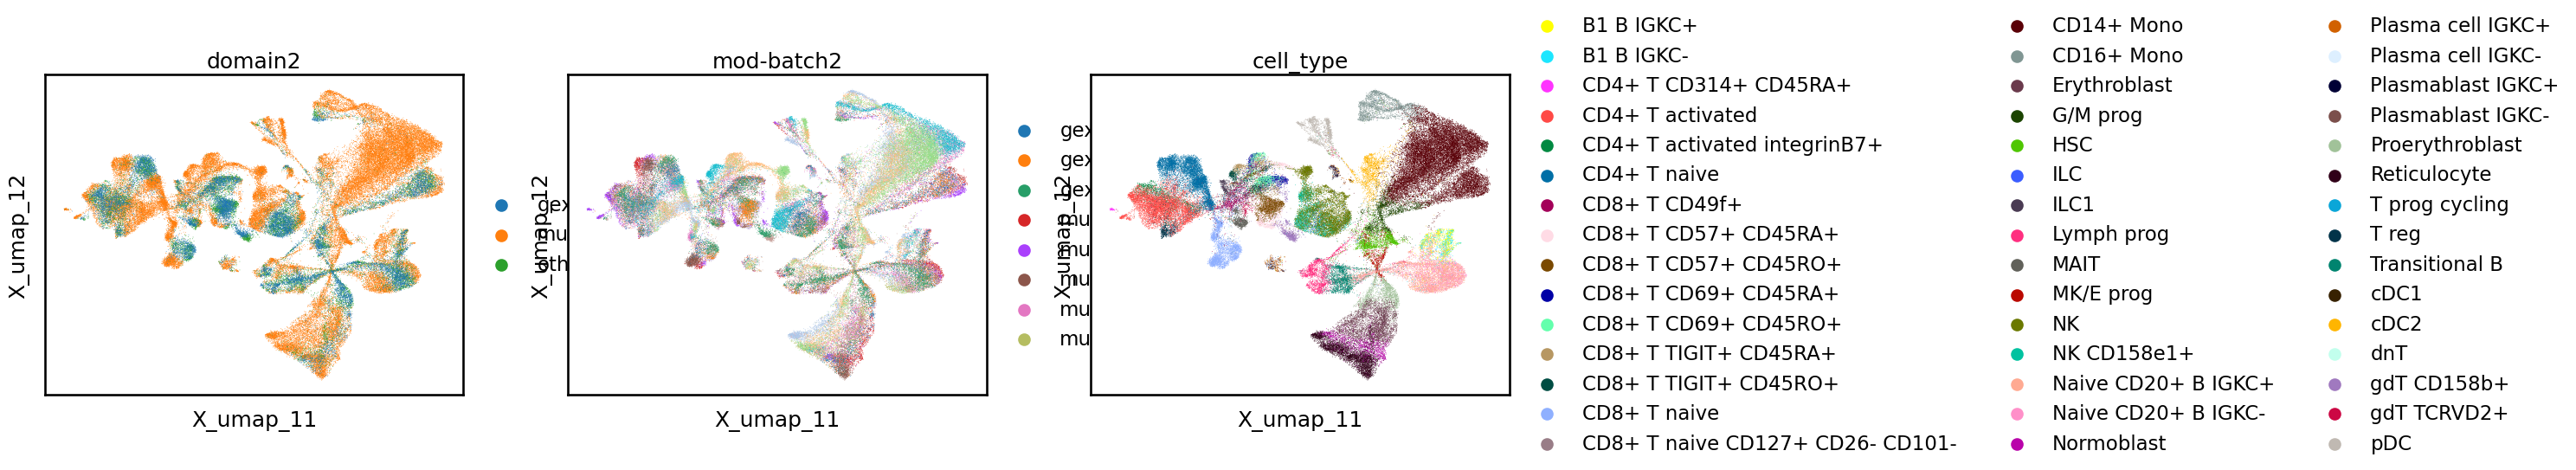

In [37]:
sc.pl.embedding(ad_mosaic, basis='X_umap_1', color=['domain2', 'mod-batch2', 'cell_type'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


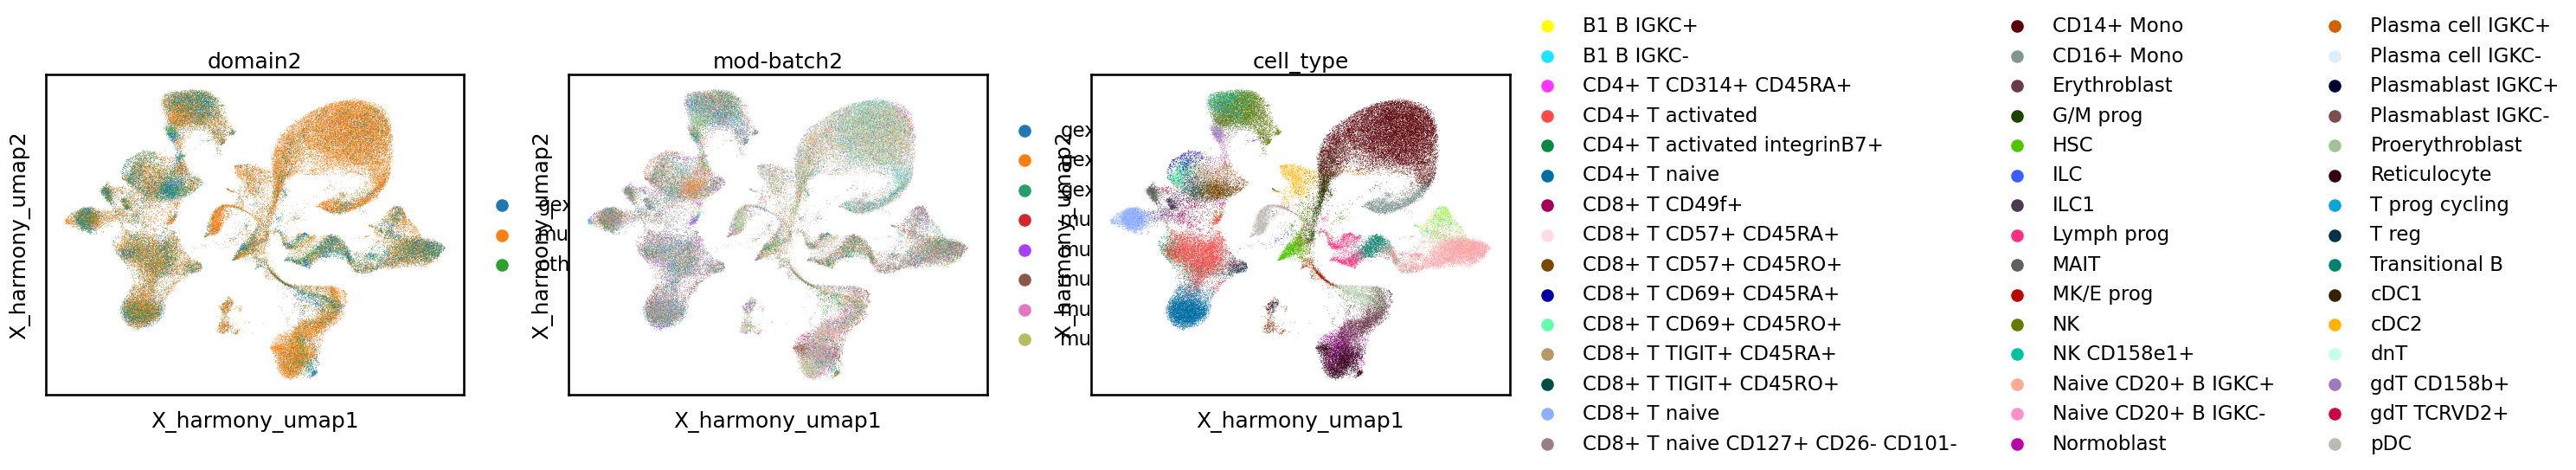

In [38]:
sc.pl.embedding(ad_mosaic, basis='X_harmony_umap', color=['domain2', 'mod-batch2', 'cell_type'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/t

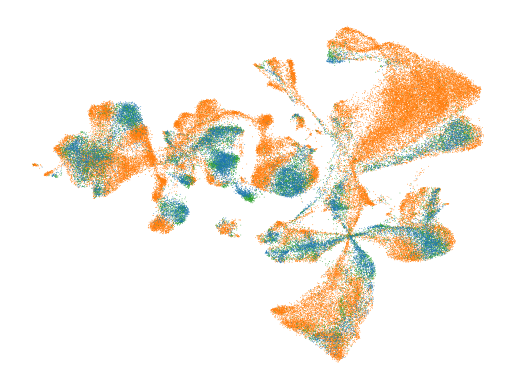

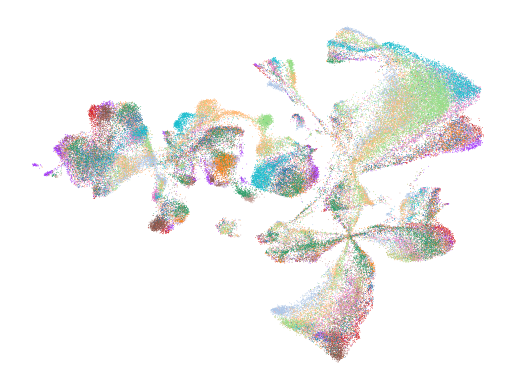

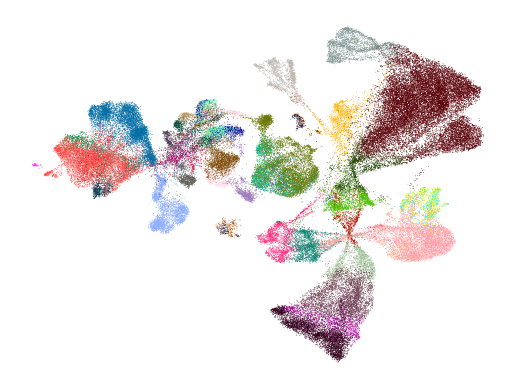

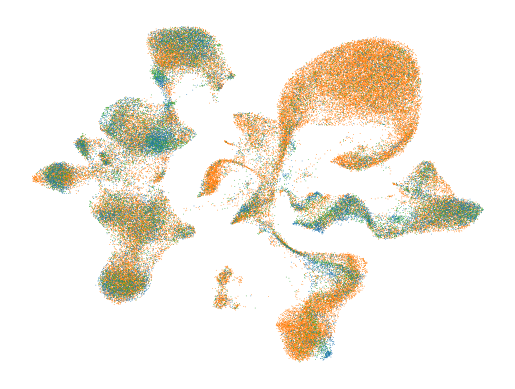

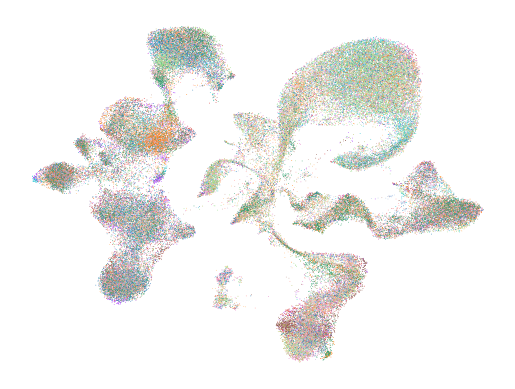

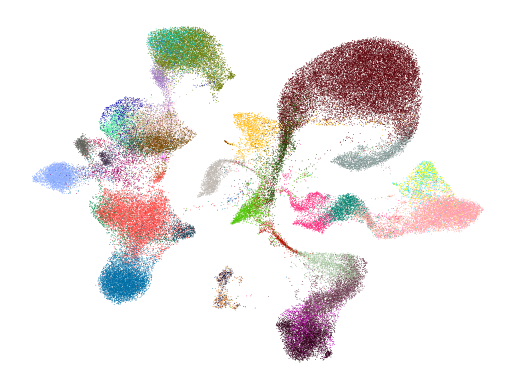

In [39]:
save_umap(ad_mosaic, 'X_umap_1', ['domain2', 'mod-batch2', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='clue_case2_cite')

save_umap(ad_mosaic, 'X_harmony_umap', ['domain2', 'mod-batch2', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='clue-harmony_case2_cite')

In [41]:
np.save(os.path.join(umap_save_dir, 'clue_case2_cite_umap.npy'), ad_mosaic.obsm['X_umap_1'])
np.save(os.path.join(umap_save_dir, 'clue-harmony_case2_cite_umap.npy'), ad_mosaic.obsm['X_harmony_umap'])